# Script Overview

This script implements a **Standard Bayesian VAR with conjugate priors** to analyze the transmission of shocks between U.S. 5 and 1-year T-Bills and Colombian TES of 5-year maturities. It estimates the model’s posterior distribution, computes impulse response functions and the FEVD to quantify how movements in U.S. interest rates affect Colombian bond yields.


## Model Specification

We consider a Bayesian VAR($p$) model of $n$ series:
$$
y_t = b_0 + \sum_{l=1}^p B_l\,y_{t-l} + u_t,\quad u_t \sim \mathcal{N}(0,\Omega).
$$
In compact form:
$$
Y = X\,B + U,\quad U\sim \mathcal{N}_{T\times n}(0,\Omega, I_T).
$$
The likelihood is
$$
p(Y\mid B,\Omega)\;\propto\;|\Omega|^{-T/2}\,
\exp\!\Bigl(-\tfrac12\,\mathrm{tr}\bigl[\Omega^{-1}(Y - X B)'(Y - X B)\bigr]\Bigr).
$$

### Minnesota Prior with Dummy Observations

We place a conjugate Normal–Inverse–Wishart prior on $(B,\Omega)$, but augment it with two sets of “dummy” observations to encode:

1. **Unit-root belief** ($\lambda_4$):  
   A single synthetic observation $\Delta y_t\approx0$ for each series, scaled by $\lambda_4^2$, which pushes the first-lag autoregressive coefficients toward unity (random-walk).

2. **Sum-of-coefficients (cointegration) belief** ($\lambda_5$):  
   A synthetic observation enforcing $\sum_{l=1}^p B_l \approx I_n$, scaled by $\lambda_5^2$, which softly imposes long-run equilibrium relations.

Concretely, define augmented data
$$
\widetilde Y = \begin{pmatrix} Y \\ Y_{\text{UR}} \\ Y_{\text{SC}} \end{pmatrix},\quad
\widetilde X = \begin{pmatrix} X \\ X_{\text{UR}} \\ X_{\text{SC}} \end{pmatrix},
$$
where the last two blocks are the dummy-row matrices built using $\lambda_4,\lambda_5$.  Then
$$
\beta=\mathrm{vec}(B)\;\big|\;\Omega\sim\mathcal{N}\bigl(\beta_0,\;\Omega\otimes H_0(\lambda)\bigr),\quad
\Omega\sim\mathcal{IW}(S_0,\nu_0),\quad \nu_0=n+2,
$$
with $H_0(\lambda)$ incorporating $\lambda_0,\lambda_1,\lambda_2,\lambda_3$ as before, and the UR/SC dummies via $\lambda_4,\lambda_5$.  

### Posterior with Augmented Data

Using $(\widetilde Y,\widetilde X)$, the posterior remains Normal–Inverse–Wishart:
$$
B\mid\Omega,\widetilde Y \sim \mathcal{N}(B^*,\,\Omega\otimes H^*),\quad
\Omega\mid\widetilde Y \sim \mathcal{IW}(S^*,\,\nu^*),
$$
where
$$
\begin{aligned}
H^* &= \bigl(H_0^{-1} + \widetilde X'\widetilde X\bigr)^{-1},\\
B^* &= H^*\bigl(H_0^{-1}B_0 + \widetilde X'\widetilde Y\,\bigr),\\
S^* &= S_0 + (\widetilde Y - \widetilde X B_0)'(\widetilde Y - \widetilde X B_0),\\
\nu^* &= T + n_{\text{dummy}} + \nu_0,
\end{aligned}
$$
with $n_{\text{dummy}}$ the number of dummy rows.  In practice, one stacks the UR and SC dummies directly, so that the prior beliefs on random-walk and cointegration are automatically folded into the posterior update.  

*Source: J. Jacobo, Una introducción a los métodos de máxima entropía y de inferencia bayesiana en econometría.* 



## Librarys 

In [1]:
import pandas as pd 
import numpy as np 
import math 
from scipy.stats import t
from scipy.linalg import det, inv
from scipy.special import gammaln , multigammaln
from scipy.optimize import minimize
from scipy.stats import invwishart
from scipy.stats import matrix_normal
import time
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


## Data processing

In [2]:
df = pd.read_excel('../data/raw/Tes-Bills Final.xlsx')

# Convertir TES-Bills a trimestral
df.set_index('Fecha', inplace=True)
df_trimestral = df.resample('QE').mean()
df_trimestral = df_trimestral.reset_index()
df_trimestral1 = df_trimestral.copy()

Final = df_trimestral1.drop('Fecha' , axis=1)
Final1 = Final[[ 'DGS5' ,'DGS1', 'TES 5 años' ]] # For normal VAR the order is not important
YY = Final1.to_numpy()

In [4]:
Final1

,DGS5,DGS1,TES 5 años
0,2.910417,1.301667,15.799212
1,2.564035,1.152807,15.060320
2,3.133548,1.216774,14.385874
3,3.244200,1.295200,14.232119
4,2.976122,1.221429,12.807968
...,...,...,...
82,4.348367,5.392857,10.487089
83,4.377447,5.175106,10.466277
84,4.217660,4.956170,9.523415
85,4.415714,5.104694,10.257280


## Plot the series


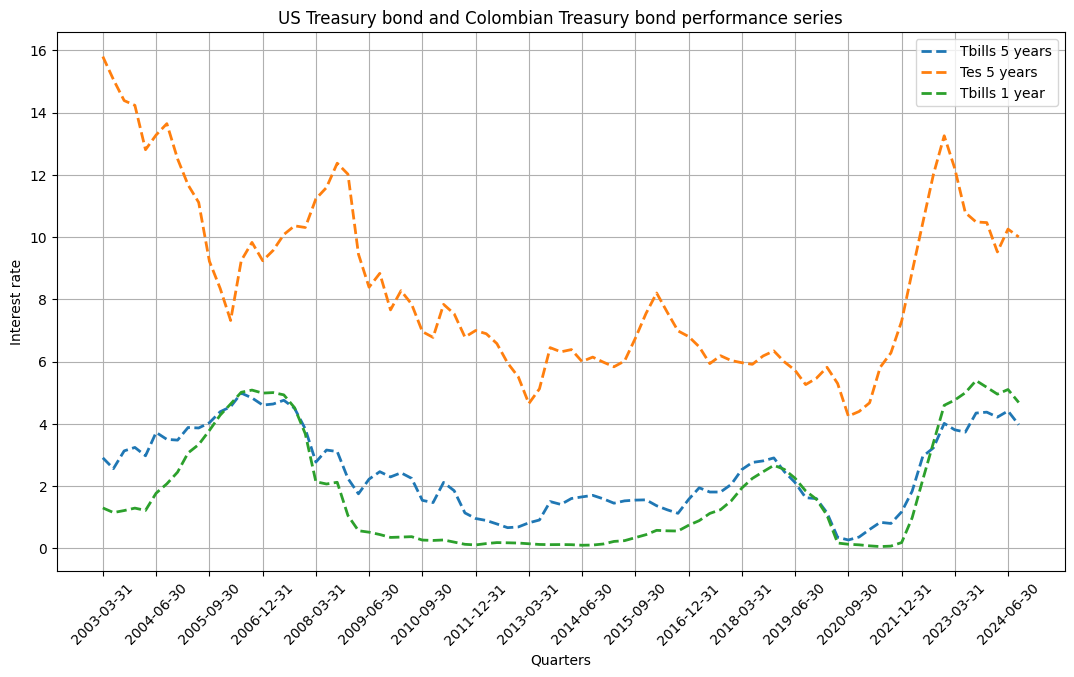

In [5]:
plt.figure(figsize=(13, 7))    
plt.plot(df_trimestral['Fecha'],df_trimestral['DGS5'], label="Tbills 5 years", 
         linewidth=2 , linestyle='--' )
plt.plot(df_trimestral['Fecha'], df_trimestral['TES 5 años'], label="Tes 5 years", 
         linewidth=2  , linestyle='--' )
plt.plot(df_trimestral['Fecha'], df_trimestral['DGS1'], label="Tbills 1 year", 
         linewidth=2  , linestyle='--' )
cuartiles_a_mostrar = df_trimestral ['Fecha'][::5]
plt.xticks(cuartiles_a_mostrar, rotation=45)
plt.xlabel('Quarters')
plt.ylabel('Interest rate')
plt.title('US Treasury bond and Colombian Treasury bond performance series')
plt.legend()
plt.grid()
plt.show()


## Optimizing hyperparameters of the Minnesota prior


We choose the Minnesota prior hyperparameters $\lambda=(\lambda_0,\lambda_1,\lambda_3,\lambda_4,\lambda_5)$ by maximizing the analytical marginal likelihood of the VAR:
$$
p(Y\mid\lambda)
= c_y(\lambda)\,
\Bigl\lvert S_0 + (Y - X B_0)^\top \bigl(I_T + X H_0(\lambda) X^\top\bigr)^{-1}(Y - X B_0)\Bigr\rvert^{-\frac{T+\nu_0}{2}},
$$
where
$$
c_y(\lambda)
= \pi^{-\frac{Tn}{2}}
\,\lvert S_0\rvert^{\frac{\nu_0}{2}}
\,\lvert I_T + X H_0(\lambda) X^\top\rvert^{-\frac{n}{2}}
\prod_{i=1}^{T}
\frac{\Gamma\!\bigl(\tfrac{\nu_0+T+1-i}{2}\bigr)}
{\Gamma\!\bigl(\tfrac{\nu_0+T+1-n-i}{2}\bigr)}.
$$
The optimal hyperparameters satisfy
$$
\hat\lambda
= \arg\max_{\lambda}\;p(Y\mid\lambda).
$$
In practice, one evaluates this closed-form marginal likelihood for candidate $\lambda$ vectors—via grid search or numerical optimization—and selects the $\lambda$ that yields the highest value, thereby calibrating the prior to maximize out-of-sample predictive performance.  


*Source: J. Jacobo, Una introducción a los métodos de máxima entropía y de inferencia bayesiana en econometría.* 


In [3]:

def decorador_2(func):
    def wrapped(*args):
        time1 = time.time()
        rta = func(*args)
        time2 = time.time()
        print('The function took' , time2-time1)
        return rta 
    return wrapped 

################  BVARS  ################
n=YY.shape[1]
p=3 # Number of lags of the model
Y=YY[p: , :]
T=Y.shape[0]
k=n*p+1
X=np.ones((T,k))

for i in range(0, p):
    X[:, (i*n):(i+1)*n] = YY[p-i-1:-i-1, :]

phi=np.linalg.inv(X.T @ X) @ (X.T@Y)

## Base for the Minnesota Prior
delta=np.zeros(n)
for i in range(0,n):
    Y_lagged = YY[p-1:-1, i].reshape(-1, 1)
    inv_term = np.linalg.inv(Y_lagged.T @ Y_lagged)
    Y_current = YY[p-1:-1,i].reshape(-1, 1)
    Y_current1 = YY[p:,i].reshape(-1, 1)
    delta[i] = (inv_term.T @ Y_current.T @ Y_current1).item()

# variance vector of the ar(1)
su=np.zeros(n)
for i in range (0,n):
    su[i]= (1/T)*sum((YY[p:,i] - delta[i]*YY[p-1:-1,i]))**(2)
s0=np.diag(su)

# define prior means for Minnesota
Ymean=np.mean(YY[:2*p,:] , axis=0)
V0d=n+2

# Estimate Lagrange multipliers based on marginal likelihood
def Marginal_likhood(lambd):
    """
    Computes the negative log-marginal likelihood of a Bayesian VAR under a conjugate
    Minnesota prior with dummy observations for unit-root and cointegration beliefs.

    This function builds the augmented data matrices (including Minnesota prior dummies),
    derives prior hyperparameters (B0d, S0d, H0), and evaluates the marginal likelihood
    by embedding a matrix-t density on residuals. It returns a scalar loss for optimizer routines.

    Steps:
      1. Extract hyperparameters: lambda0, lambda1, lambda3, lambda4, lambda5.
      2. Construct Minnesota prior dummy blocks:
         - Trend and lag decay via lambda0 and lambda1 over p lags.
         - Intercept shrinkage via lambda3.
      3. Build unit-root (λ4) and sum-of-coefficients (λ5) dummy observations:
         - UR: enforces first-difference close to zero.
         - SC: enforces sum of AR coefficients close to one.
      4. Stack real and dummy data into YP (responses) and XP (regressors).
      5. Compute prior moments:
         - B0d = (XP'XP)^{-1} XP' YP
         - S0d = (YP - XP B0d)'(YP - XP B0d)
         - H0  = (XP'XP)^{-1}
      6. Compute marginal likelihood components:
         - HHi = (I_T + X H0 X')^{-1}
         - detS0  = |S0d|
         - detPrinc = |S0d + (Y - X B0d)' HHi (Y - X B0d)|
      7. Parameterize matrix-t distribution on transposed data Z = Y'.
      8. Call nested t_multivariate() to compute negative log-density of Z under matrix-t.

    Returns:
        float: Negative log-marginal likelihood; suitable as optimizer objective.
    """
    
    lambd0 , lambd1 = lambd[0] , lambd[1]
    lambd3 , lambd4 = lambd[2] , lambd[3]
    lambd5 = lambd[4]

    ## Minnesota Prior
    Jp = np.diag([i for i in range(1,p+1)]) **(lambd1)
    YD1 = np.vstack((np.diag((delta * np.sqrt(su)) / lambd0) , np.zeros((n*(p-1) , n))))
    kron_result=np.kron(Jp , np.sqrt(s0)/lambd0) 
    XD1 = np.hstack((kron_result , np.zeros((n*p,1))))
    Ycov = np.sqrt(s0)
    Xcov = np.zeros((n,n*p+1))
    XDc = np.hstack((np.zeros((1,n*p)) , np.array([[1/(lambd0*lambd3)]])))
    YDc = np.zeros((1,n))
    YD = np.vstack((YD1,YDc, Ycov))
    XD = np.vstack((XD1 , XDc , Xcov))

    # prior of unit root
    Ys = np.diag(Ymean / lambd4)
    kron_result1=np.kron(np.ones((1,p)), Ys)
    Xs = np.hstack((kron_result1 , np.zeros((n,1))))

    # cointegration prior
    Y0 = np.array(Ymean / lambd5).reshape(1, -1)
    kron_result2=np.kron(np.ones((1,p)), Y0)
    X0 = np.hstack((kron_result2 , np.array([[1/lambd5]])))
    YP = np.vstack((YD,Ys, Y0))
    XP = np.vstack((XD,Xs, X0))

    # prior parameters
    B0d = np.linalg.inv(XP.T @ XP) @ (XP.T @ YP)
    v0d = n+2
    resta = YP-XP @ B0d
    S0d1 = np.matrix(resta.T @ resta)
    S0d = S0d1.getH()
    S0d = np.asarray(S0d)

    # H0:
    h0= np.matrix(np.linalg.inv(XP.T @ XP))
    H0 = h0.getH()
    H0 = np.asarray(H0)
    hh= np.matrix(np.eye(T)+ X@H0@X.T)
    HH = hh.getH()
    HH = np.asarray(HH)
    hhi = np.matrix(np.linalg.inv(HH))
    HHi = hhi.getH()
    HHi = np.asarray(HHi)
    detS0 = np.linalg.det(S0d)
    detPrinc = np.linalg.det(S0d + (Y-X@B0d).T @ HHi @ (Y-X@B0d))

    # Parameters of matrix t 
    Z = Y.T
    M = (X@B0d).T
    Omegat = HH
    sigmat = S0d
    v = v0d  -n+1

    def t_multivariada(nu, M, Sigma, Omega, X):
        """
    Computes the negative log-density of the matrix-variate Student's t distribution.

    This function evaluates the log-density of the data matrix X under a matrix-variate
    Student's t distribution with degrees of freedom nu, location matrix M, and scale matrices
    Sigma (row covariance) and Omega (column covariance). It is structured for use as an
    objective function in optimization routines, returning a scalar loss proportional to
    the negative log-likelihood of X.

    Nested helper using:
          - nu: degrees of freedom
          - M: location (mean) matrix
          - Sigma: row covariance
          - Omega: column covariance
          - X: observed data matrix

        Returns a large penalty (1e5) if density invalid.
    """
        n, p = X.shape

        gamma1 = multigammaln((nu + n + p - 1) / 2, p)
        gamma2 = multigammaln((nu + p - 1) / 2, p) + (n * p / 2) * np.log(np.pi)

        sign_Omega, logdet_Omega = np.linalg.slogdet(Omega)
        sign_Sigma, logdet_Sigma = np.linalg.slogdet(Sigma)
    
        log_c0 = gamma1 - gamma2 - (n / 2) * logdet_Omega - (p / 2) * logdet_Sigma

        centered_X = X - M
        inv_Sigma = np.linalg.inv(Sigma)
        inv_Omega = np.linalg.inv(Omega)
        I_n = np.eye(n)

        inside_term = I_n + inv_Sigma @ centered_X @ inv_Omega @ centered_X.T
        sign_inside, logdet_inside = np.linalg.slogdet(inside_term)

        exponent = -(nu + n + p - 1) / 2
        density_log = log_c0 + exponent * logdet_inside

        if -density_log <= 0:
            return 1e5
        else:
            return -density_log
        
    return t_multivariada(v, M, sigmat, Omegat , Z)

np.seterr(divide='ignore', invalid='ignore')
bounds = [(-5,5) , (-5,5) , (-5,5)  , (-5,5) ,  (-5,5) ]
Resultado = None

for i in range(10):  
    initial_params = np.random.uniform(-4, 3, size=5)
    result = minimize(Marginal_likhood, initial_params, method='L-BFGS-B', bounds=bounds)
    if result.success:
        if Resultado is None or result.fun < Resultado.fun:
            Resultado = result
    else:
        print(f"Optimization {i+1} did not converge: {result.message}")


print("Optimization result:", result)

    

Optimization 1 did not converge: ABNORMAL: 
Optimization 3 did not converge: ABNORMAL: 
Optimization 4 did not converge: ABNORMAL: 
Optimization 5 did not converge: ABNORMAL: 
Optimization 7 did not converge: ABNORMAL: 
Optimization 8 did not converge: ABNORMAL: 
Optimization 9 did not converge: ABNORMAL: 
Optimization result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 123.31133824092308
        x: [ 4.202e-01  1.186e+00 -1.865e-01  1.087e-01  9.614e-04]
      nit: 15
      jac: [ 2.646e+02  2.740e+02  9.702e+01  1.814e+02  1.314e+02]
     nfev: 570
     njev: 95
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


## Generate samples from the Posterior distribution

In [4]:

lambd0 , lambd1 , lambd3 , lambd4 , lambd5 = result.x

YD1 = np.vstack((np.diag((delta * np.sqrt(su)) / lambd0) , np.zeros((n*(p-1) , n))))
YDc = np.zeros((1,n))
Jp = np.diag([i for i in range(1,p+1)]) **(lambd1)

kron_result=np.kron(Jp , np.sqrt(s0)/lambd0) 
XD1 = np.hstack((kron_result , np.zeros((n*p,1))))
Ycov = np.sqrt(s0)
Xcov = np.zeros((n,n*p+1))
XDc = np.hstack((np.zeros((1,n*p)) , np.array([[1/(lambd0*lambd3)]])))
YD = np.vstack((YD1, Ycov ,YDc))
XD = np.vstack((XD1 , Xcov ,XDc))
Ys = np.diag(Ymean / lambd4)
kron_result1=np.kron(np.ones((1,p)), Ys)
Xs = np.hstack((kron_result1 , np.zeros((n,1))))

# cointegration prior
Y0 = np.array(Ymean / lambd5).reshape(1, -1)
kron_result2=np.kron(np.ones((1,p)), Y0)
X0 = np.hstack((kron_result2 , np.array([[1/lambd5]])))
YP = np.vstack((YD,Ys, Y0))
XP = np.vstack((XD,Xs, X0))
B0d = np.linalg.inv(XP.T @ XP) @ (XP.T @ YP)
TD= YP.shape[0]
v0d = n+2
S0 = (YP - XP @ B0d).T @ (YP - XP @ B0d)

# create posterior observations
Yst = np.vstack((Y , YP))
Xst = np.vstack((X , XP))
Bps = np.linalg.inv(Xst.T @ Xst) @ (Xst.T @ Yst)
hs= np.matrix(np.linalg.inv(Xst.T @ Xst))
Hs = hs.getH()
Hs= np.asarray(Hs)
ss= np.matrix((Yst - (Xst @ Bps)).T @ (Yst - (Xst @ Bps)))
Ss = ss.getH()
Ss= np.asarray(Ss)
V0d = n+2
vd = T + V0d 

@decorador_2
def Posterior_obs(v,S,phi,H,R):
    """
    Draws R samples from the posterior of (Ω, B) for the Bayesian VAR model.

    This function performs the following steps:
      1. Initialize arrays:
         - omegaS: shape (n, R, n), to store precision matrix draws Ωᵢ.
         - Bs:     shape (k, R, n), to store coefficient matrix draws Bᵢ.

      2. For each draw i = 1..R:
         a) Sample Ωᵢ from the Inverse-Wishart distribution with degrees of freedom v
            and scale matrix S: Ωᵢ ~ IW(v, S).
         b) Sample Bᵢ from the Matrix-Normal distribution with mean matrix phi,
            row covariance H, and column covariance Ωᵢ: Bᵢ ~ MN(phi, H, Ωᵢ).

    Returns:
        omegaS (ndarray): Array of shape (n, R, n) with Ω draws.
        Bs     (ndarray): Array of shape (n, R, k) with B draws (transposed internally).
    """

    omegaS= np.zeros((n,R,n))
    Bs = np.zeros((k,R, n))
    for i in range (0,R):
        omegaS[:,i,:] = invwishart.rvs(df=v, scale=S)
        Bs[:,i,:] = matrix_normal.rvs(phi , H , omegaS[:,i,:])
    return omegaS , Bs.T

R= 80000 # Number of samples 
omegas,Bs= Posterior_obs(vd , Ss , Bps , Hs , R) 


The function took 21.439205169677734


In [5]:
print('Posterior CoVariance Dimensions' , omegas.shape)
print('Dimensions of the posterior of the coefficients' , Bs.shape)

Posterior CoVariance Dimensions (3, 80000, 3)
Dimensions of the posterior of the coefficients (3, 80000, 10)


## Markov Chain Analysis

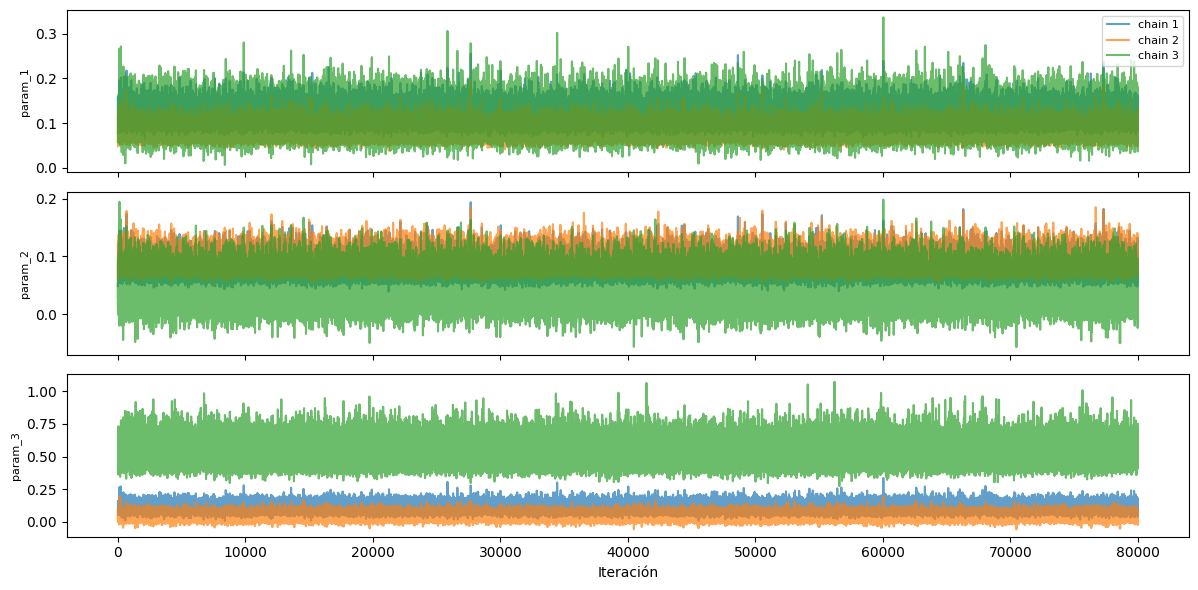

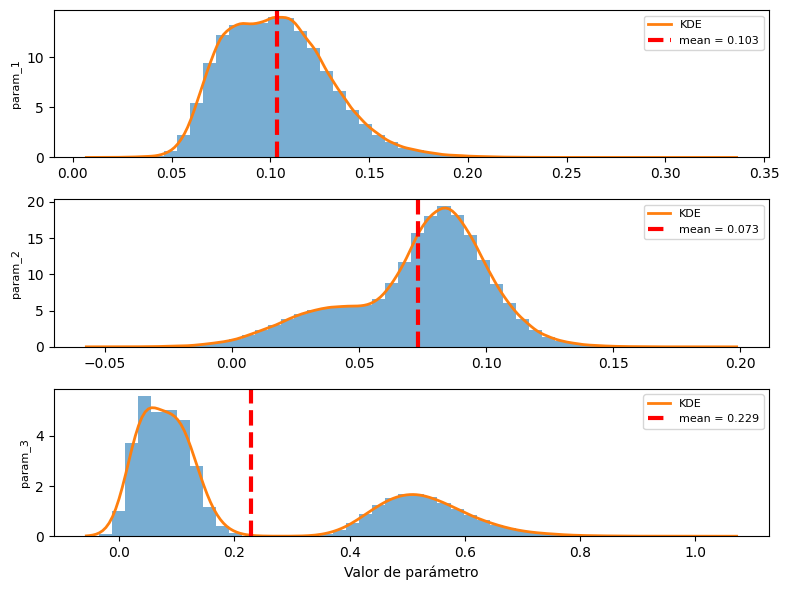

In [22]:
### OMEGA PARAMETERS 
n_chains, n_samples, n_params = omegas.shape
param_names = [f"param_{i+1}" for i in range(n_params)]


fig, axes = plt.subplots(n_params, 1, figsize=(12, 2*n_params), sharex=True)
for i, ax in enumerate(axes):
    for c in range(n_chains):
        ax.plot(omegas[c, :, i], alpha=0.7)  
    ax.set_ylabel(param_names[i], fontsize=8)
    if i == 0:
        ax.legend([f"chain {c+1}" for c in range(n_chains)], loc="upper right", fontsize=8)
axes[-1].set_xlabel("Iteración", fontsize=10)
plt.tight_layout()
plt.show()

posterior_samples = omegas.reshape(-1, n_params)  

fig, axes = plt.subplots(n_params, 1, figsize=(8, 2 * n_params))

for i, ax in enumerate(axes):
    samples = posterior_samples[:, i]
    ax.hist(samples, bins=50, density=True, alpha=0.6)

    kde = gaussian_kde(samples)
    xs = np.linspace(samples.min(), samples.max(), 200)
    ax.plot(xs, kde(xs), linewidth=2, label="KDE")


    mean_val = samples.mean()
    ax.axvline(mean_val,color='red',          
        linestyle='--',linewidth=3,label=f"mean = {mean_val:.3f}")
    ax.set_ylabel(param_names[i], fontsize=8)
    ax.legend(fontsize=8)

axes[-1].set_xlabel("Valor de parámetro", fontsize=10)
plt.tight_layout()
plt.show()

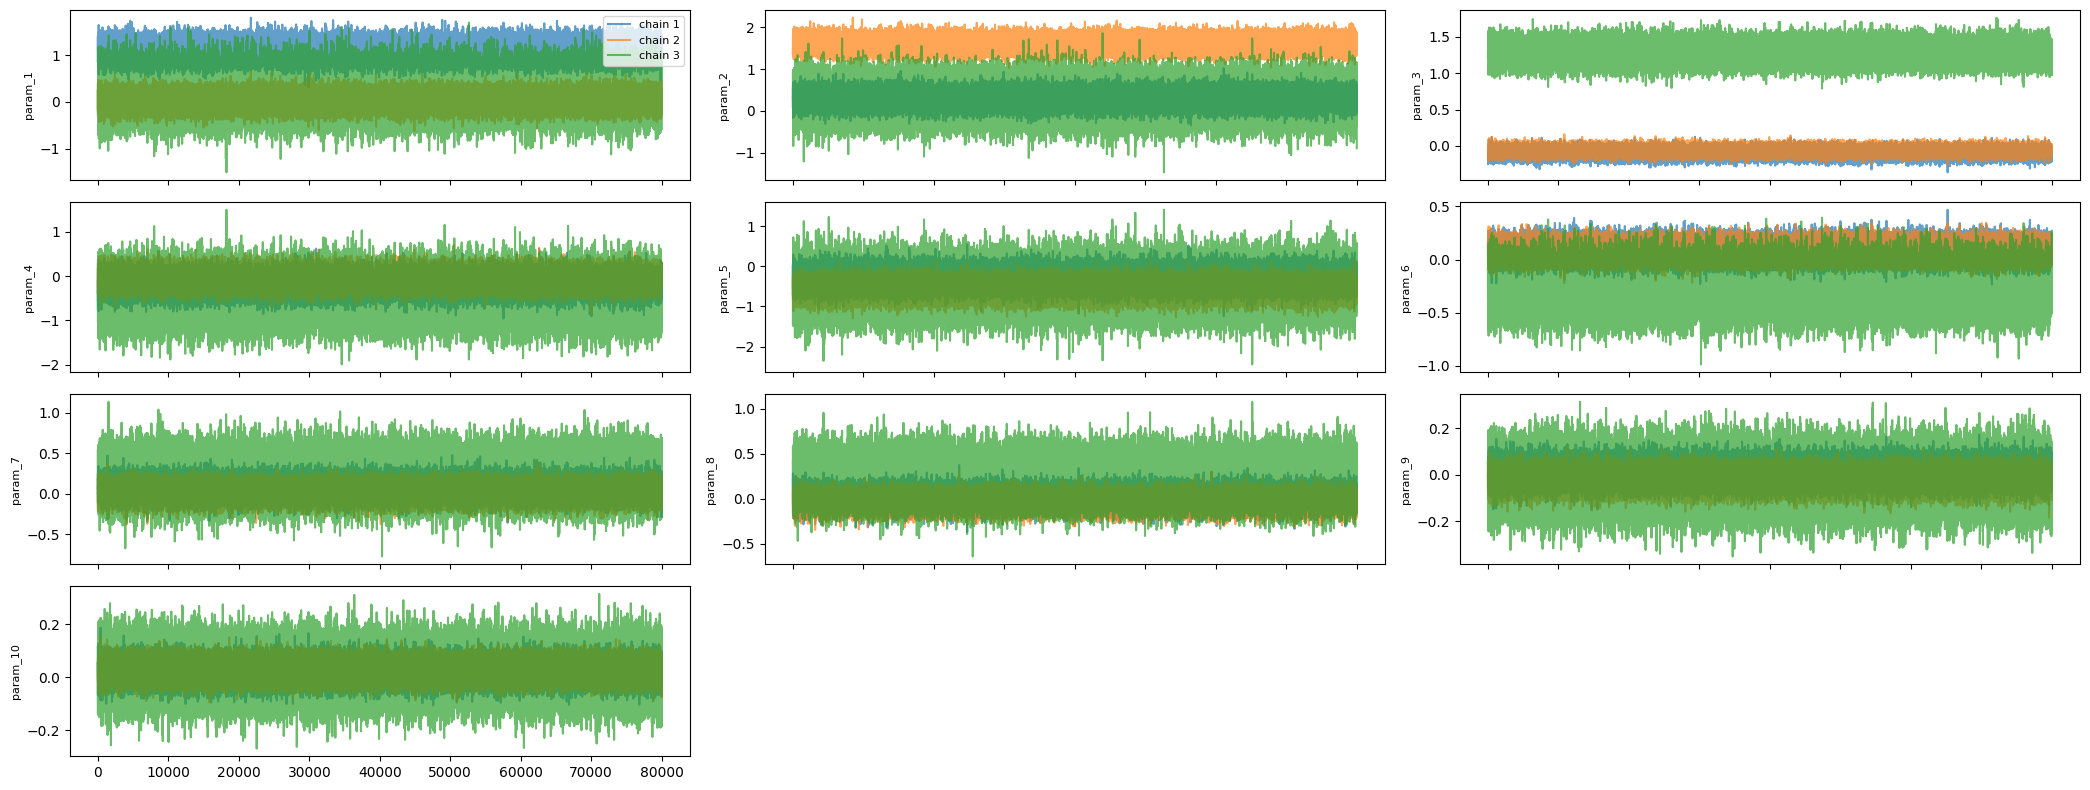

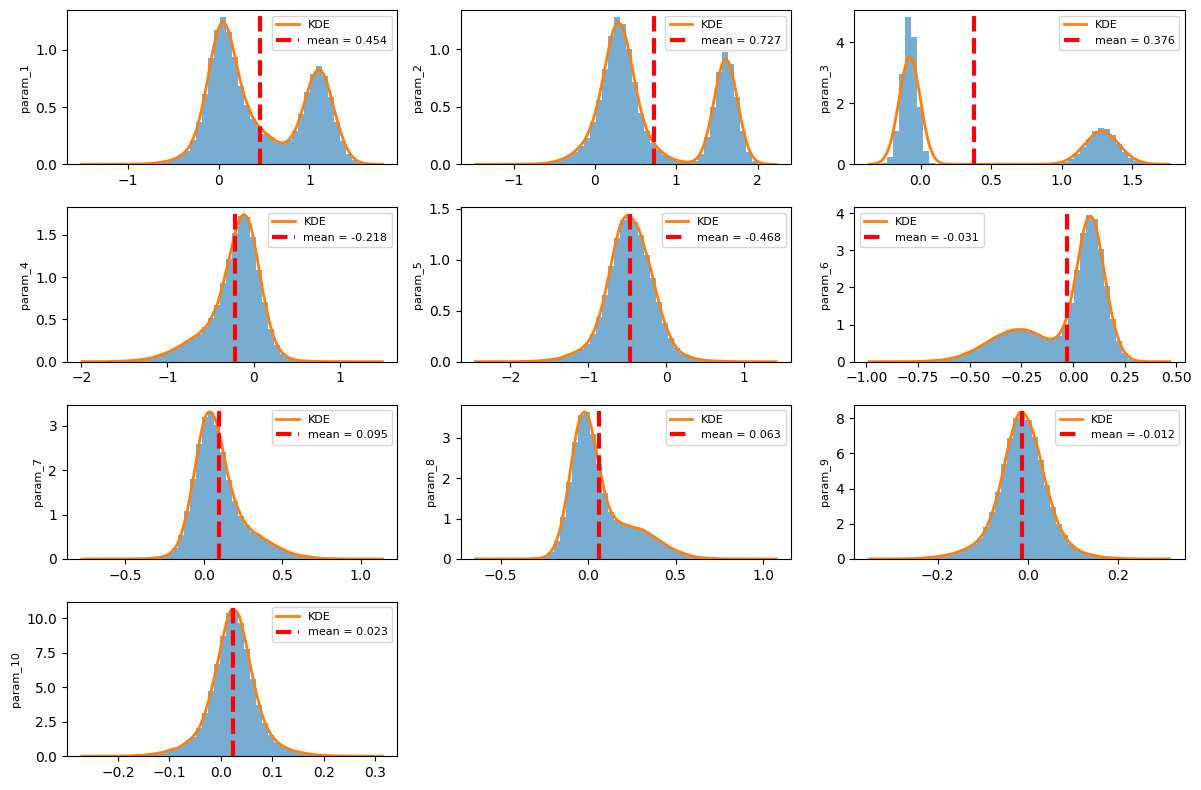

In [21]:
### BS PARAMETERS 
n_chains, n_samples, n_params = Bs.shape
param_names = [f"param_{i+1}" for i in range(n_params)]

if n_params <= 5:
    ncols, nrows = 1, n_params
else:
    ncols = 3
    nrows = math.ceil(n_params / ncols)

# -- TRACE PLOTS ------------------------------------------------------
fig, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 2*nrows), sharex=True)
axes = axes.flatten()

for i in range(n_params):
    ax = axes[i]
    for c in range(n_chains):
        ax.plot(Bs[c, :, i], alpha=0.7)
    ax.set_ylabel(param_names[i], fontsize=8)
    if i == 0:
        ax.legend([f"chain {c+1}" for c in range(n_chains)],
                  loc="upper right", fontsize=8)

# clean axis
for j in range(n_params, len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Iteración", fontsize=10)
plt.tight_layout()
plt.show()


# -- DENSITY + KDE PLOTS --------------------------------------------
posterior_samples = Bs.reshape(-1, n_params)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 2*nrows), sharex=False)
axes = axes.flatten()

for i in range(n_params):
    ax = axes[i]
    samples = posterior_samples[:, i]

    # hist
    ax.hist(samples, bins=50, density=True, alpha=0.6)

    # KDE
    kde = gaussian_kde(samples)
    xs = np.linspace(samples.min(), samples.max(), 200)
    ax.plot(xs, kde(xs), linewidth=2, label="KDE")

    mean_val = samples.mean()
    ax.axvline(mean_val,color='red',linestyle='--',linewidth=3,label=f"mean = {mean_val:.3f}")

    ax.set_ylabel(param_names[i], fontsize=8)
    ax.legend(fontsize=8)


for j in range(n_params, len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Valor de parámetro", fontsize=10)
plt.tight_layout()
plt.show()

## Impulse Response Functions (IRFs)



Given the VAR($p$) in companion form,
$$
Y_t = F\,Y_{t-1} + v_t,
$$
where 
$$
Y_t = \begin{pmatrix}y_t \\ y_{t-1} \\ \vdots \\ y_{t-p+1}\end{pmatrix},\quad
F = \begin{pmatrix}
B_1 & B_2 & \cdots & B_{p-1} & B_p\\
I_n & 0 & \cdots & 0 & 0\\
0 & I_n & \ddots & 0 & 0\\
\vdots & & \ddots & \ddots & \vdots\\
0 & 0 & \cdots & I_n & 0
\end{pmatrix},\quad
v_t = \begin{pmatrix}u_t \\ 0 \\ \vdots \\ 0\end{pmatrix},
$$
the $h$-step impulse response from a shock in series $j$ to series $i$ is defined as
$$
\mathrm{IRF}_{ij}(h)
= \frac{\partial\,y_{i,t+h}}{\partial\,u_{j,t}}
= \bigl[e_i'\,F^h\,e_{j}^{(1)}\bigr],
$$
where $e_i$ selects the $i$-th component of $y$ and $e_{j}^{(1)}$ selects the $j$-th element of $u_t$ in the first block.  
Equivalently, stacking only the first $n$ rows,
$$
\mathrm{IRF}(h) = J\,F^h\,J',
$$
with $J = \begin{pmatrix}I_n & 0_{n\times n(p-1)}\end{pmatrix}$.  

Thus, each matrix $\mathrm{IRF}(h)\in\mathbb{R}^{n\times n}$ gives the dynamic effect at horizon $h$ of a one-unit shock to each variable on all variables in the system.  


In [18]:

def bigAs(Omega_ds):
    """
    Compute Cholesky factors of posterior covariance draws for the VAR residuals.

    This function takes a collection of posterior draws of the VAR residual covariance 
    matrix (Ω) and returns their lower-triangular Cholesky factors.

    Parameters
    ----------
    Omega_ds : ndarray, shape (n, R, n)
        Posterior draws of the VAR residual covariance matrix Ω.
        Each Ω_i (i=0,…,R-1) is an n×n positive-definite matrix sampled from 
        the posterior distribution of the VAR error covariance.

    Returns
    -------
    As : ndarray, shape (n, n, R)
        Array of Cholesky factors A_i such that A_i @ A_i.T = Ω_i for each draw.
        The i-th slice As[:, :, i] is the lower-triangular matrix A_i.
    """
    R, n, _ = Omega_ds.shape
    As = np.empty((n, n, R))
    for i in range(R):
        As[:, :, i] = np.linalg.cholesky(Omega_ds[i])
    return As


def bigPsi(Bs):
    """
    Construct companion-form transition matrices from posterior VAR coefficient draws.

    This function takes R draws of an estimated VAR’s coefficient matrices and
    assembles, for each draw, the corresponding block companion matrix Ψ of dimension
    (n⋅p)×(n⋅p). The companion form is useful for forecasting, computing IRFs, and
    other state-space operations.

    Parameters
    ----------
    Bs : ndarray
        Posterior draws of the VAR coefficient block [B₁, …, B_p, intercept].  
        - If shape is (R, n, k), axis-1 indexes the n endogenous variables and  
          axis-2 indexes the k = n⋅p (+1 intercept) regressors.  
        - If shape is (R, k, n), the array is automatically transposed.  
        The intercept column (if present) is dropped before building Ψ.

    Returns
    -------
    psi : ndarray, shape (n⋅p, n⋅p, R)
        Companion-form matrices for each draw.  
        For draw i, psi[:, :, i] =  
        [B₁ … B_p]  
        [Iₙ    0 ]  
        [  Iₙ  0 ]  
        [  …    … ]  
        stacking p blocks of size n.
    """
    # --- orient so axis-1 is n ------------------------------------
    if Bs.shape[1] < Bs.shape[2]:           
        Bs_ok = Bs
    elif Bs.shape[2] < Bs.shape[1]:        
        Bs_ok = Bs.transpose(0, 2, 1)
    else:
        raise ValueError("No axis of Bs equals n")
    R, n, k_total = Bs_ok.shape

    # --- drop intercept if present --------------------------------
    if (k_total - 1) % n == 0:           
        top_coeff = Bs_ok[:, :, :-1]       
    else:                                   
        top_coeff = Bs_ok
    p = top_coeff.shape[2] // n
    assert p >= 1, "Unable to infer p"

    # --- build companion matrices ---------------------------------
    psi = np.empty((n * p, n * p, R))

    # lower block [ I_{n(p-1)}  0 ]
    I = np.eye(n * (p - 1))
    Z = np.zeros((n * (p - 1), n))
    bottom = np.hstack((I, Z))             

    for i in range(R):
        top = top_coeff[i]                
        psi[:, :, i] = np.vstack((top, bottom))
    return psi


def IRF_MC(omegaS , Bs, HOR):
    """
    Compute Monte Carlo impulse response functions from posterior draws.

    This function uses R posterior draws of the VAR residual covariance (Ω) and
    coefficient matrices (B) to generate impulse response functions (IRFs)
    over a specified horizon. It constructs companion-form transition matrices
    and Cholesky factors for each draw, then stacks the IRFs into a 3D array.

    Parameters
    ----------
    omegaS : ndarray
        Posterior draws of the VAR residual covariance matrix Ω.
        Each draw i gives Ω_i ∈ ℝⁿ×ⁿ.
    Bs : ndarray
        Posterior draws of the VAR coefficient matrices [B₁,…,B_p, intercept].
        The function automatically orients axes so that axis-1 corresponds to the
        n endogenous variables. The intercept column (if present) is dropped.
    HOR : int
        Forecast horizon (number of periods ahead) for which to compute IRFs.

    Returns
    -------
    GIR : ndarray, shape (n, n*(HOR+1), R)
        Generalized impulse response array. For draw i and horizon h:
        GIR[:, h*n:(h+1)*n, i] contains the n×n matrix of IRFs at horizon h,
        measuring the response of each variable to a one-unit shock in each
        contemporaneous error term.

    Notes
    -----
    1. Uses `bigAs(omegaS)` to compute Cholesky factors A_i of each Ω_i.
    2. Uses `bigPsi(Bs)` to build companion-form matrices Ψ_i of size (n·p)×(n·p).
    3. The selection matrix J = [Iₙ | 0] extracts the first block of the state vector.
    4. At horizon 0, IRF = A_i. For h ≥ 1:
       IRF(h) = J · Ψ_i^h · Jᵀ · A_i.
    """
    R, n, _ = omegaS.shape
    As  = bigAs(omegaS)      
    psi = bigPsi(Bs)      
    p   = psi.shape[0] // n

    J = np.hstack((np.eye(n), np.zeros((n, n * (p - 1))))) 

    GIR = np.zeros((n, n * (HOR + 1), R))

    for i in range(R):
        B0      = As[:, :, i]          # contemporaneous multiplier
        A_power = psi[:, :, i]         # Ψ^1 initially

        GIR[:, :n, i] = B0            # horizon 0

        for h in range(1, HOR + 1):
            col = slice(h * n, (h + 1) * n)
            GIR[:, col, i] = J @ A_power @ J.T @ B0
            A_power = A_power @ psi[:, :, i]   # Ψ^{h+1}

    return GIR


def IRF_from_posterior(omegas_post,Bs_post,HOR):
    """
    Your chain gives:
        omegas_post : (n, R, n)
        Bs_post     : (n, R, n*p + 1)

    This wrapper just re-orders axes and calls IRF_MC.
    """
    omegaS = omegas_post.transpose(1, 0, 2)  
    Bs_mat = Bs_post.transpose(1, 0, 2)       
    return IRF_MC(omegaS, Bs_mat, HOR)

HOR = 35
MCIF = IRF_from_posterior(omegas, Bs, HOR)


## Calculate confidence bands on the IRFs

In [19]:

_, total_cols, R = MCIF.shape
assert total_cols == n * (HOR + 1)

# ─────────────────────────────────────────────────────────
# Mean of the MCIF  ≡ reshape(mean(MCIRF, dims=3), n, n*(HOR+1))
# ─────────────────────────────────────────────────────────

m_IRF = MCIF.mean(axis=1)             

# ────────────────────────────────────────────────────────────
# Quantiles for confidence bands: q_{.90, .84, .50, .10, .16} 
# ────────────────────────────────────────────────────────────
q_90 = np.zeros((n, n, HOR))
q_84 = np.zeros((n, n, HOR))
q_50 = np.zeros((n, n, HOR))
q_10 = np.zeros((n, n, HOR))
q_16 = np.zeros((n, n, HOR))

for i in range(n):                 # response-variable
    for j in range(n):             # shock
        for h in range(HOR):       # horizon 0..HOR-1 
            col = j + h * n                   
            draw_vec = MCIF[i, col, :]          # vector of length R
            q_90[i, j, h] = np.quantile(draw_vec, 0.95)
            q_84[i, j, h] = np.quantile(draw_vec, 0.84)
            q_50[i, j, h] = np.quantile(draw_vec, 0.50)
            q_10[i, j, h] = np.quantile(draw_vec, 0.05)
            q_16[i, j, h] = np.quantile(draw_vec, 0.16)

# ─────────────────────────────────────────────────────────
# Error bands
# ─────────────────────────────────────────────────────────
er_90 = q_90 - q_50
er_84 = q_84 - q_50
er_10 = q_50 - q_10
er_16 = q_50 - q_16



## Graph IRFs

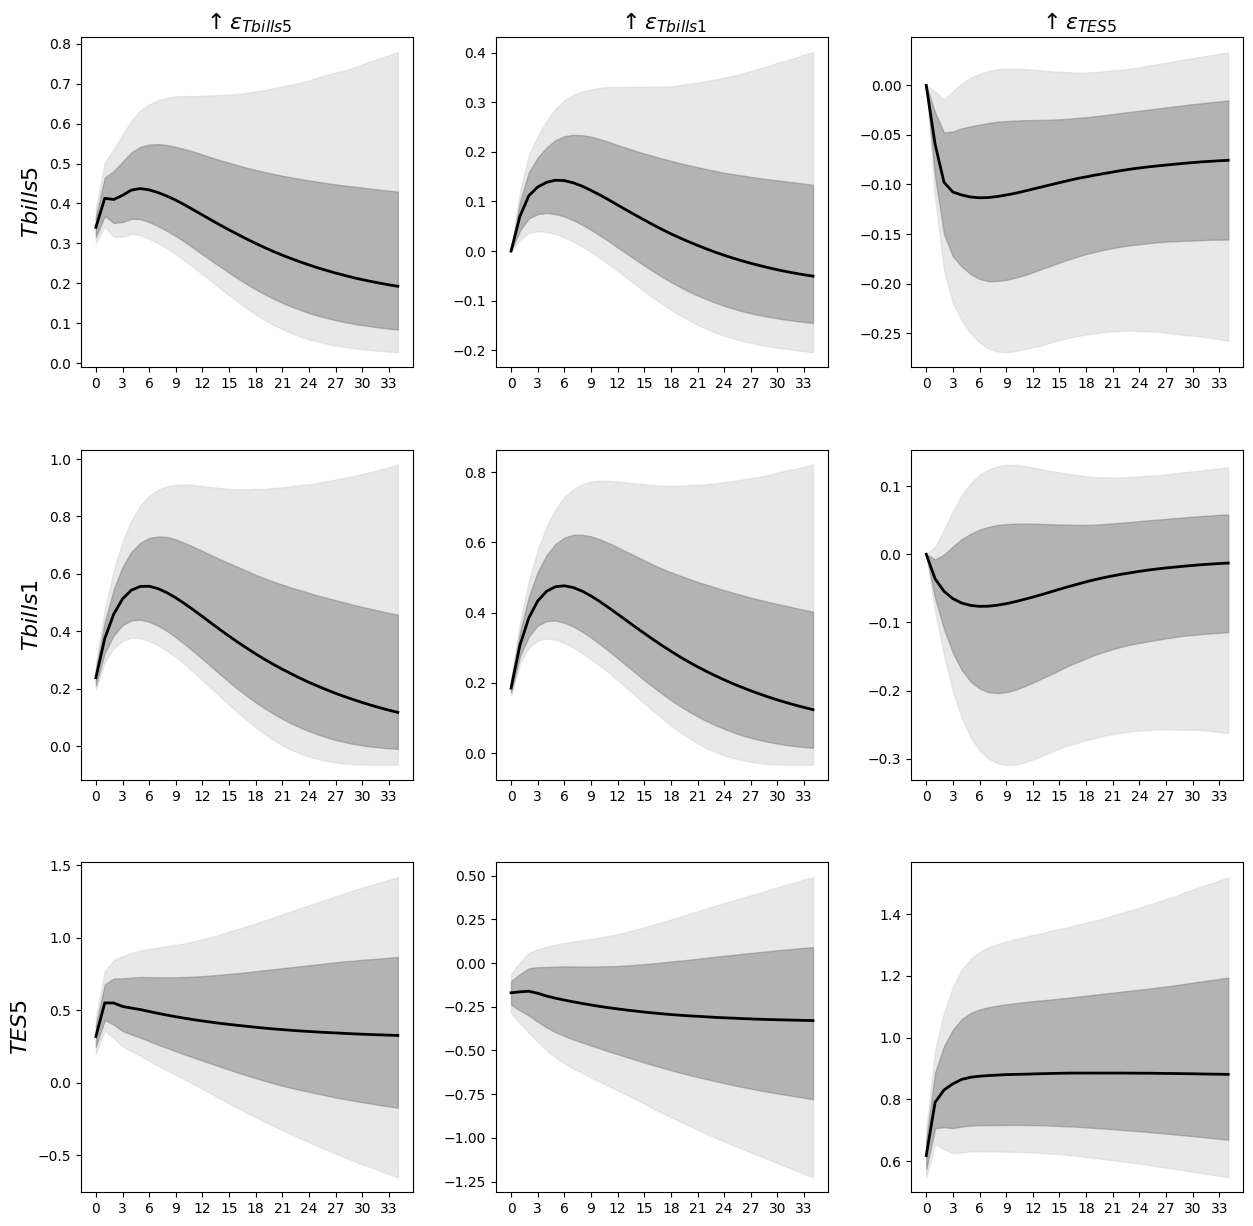

In [20]:

n   = q_50.shape[0]
HOR = q_50.shape[2]

shock_titles = [r'\uparrow \epsilon_{Tbills5}',r'\uparrow \epsilon_{Tbills1}',r'\uparrow \epsilon_{TES5}']
response_labels = [r'Tbills5',r'Tbills1',r'TES5']

fig, axes = plt.subplots(n, n, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

x_axis = np.arange(HOR)            
for row in range(n):           
    for col in range(n):       
        ax = axes[row, col]

        # Central series and bands (q_50[row,col,:] etc.)
        center = q_50[row, col, :]
        lower_90 = center - er_10[row, col, :]
        upper_90 = center + er_90[row, col, :]
        lower_68 = center - er_16[row, col, :]
        upper_68 = center + er_84[row, col, :]

        ax.plot(x_axis, center, color='black', linewidth=2)

        # Band 90 % (5–95)
        ax.fill_between(x_axis, lower_90, upper_90, color='lightgray', alpha=0.5)
        # Band 68 % (16–84)
        ax.fill_between(x_axis, lower_68, upper_68, color='gray', alpha=0.5)

        if row == 0:
            ax.set_title(f'${shock_titles[col]}$', fontsize=16, family='serif')

        if col == 0:
            ax.set_ylabel(f'${response_labels[row]}$', fontsize=16, family='serif')


        y_min = min(lower_90.min(), lower_68.min())
        y_max = max(upper_90.max(), upper_68.max())
        margin = 0.05 * (y_max - y_min)
        ax.set_ylim(y_min - margin, y_max + margin)
        ax.set_xticks(np.arange(0, HOR, 3))
        ax.tick_params(axis='both', labelsize=10)

plt.show()


### Note on IRF Interpretation

Some of the impulse response functions above may appear unclear or exhibit unexpected patterns. This is because we are using a **standard VAR** model (not structural), so the shocks $u_t$ are not orthogonalized and may be correlated across equations. In contrast, a **Structural Bayesian VAR (SBVAR)** imposes identifying restrictions to isolate structural shocks, yielding cleaner IRFs.

You can find the SBVAR implementation and a detailed explanation of how orthogonalization and identification affect IRF shapes in my GitHub repository, which clarifies why some of the responses here look atypical.  


# FEVD

In [24]:

def FEVD(IR, n, s):
    """
    Compute the Forecast Error Variance Decomposition (FEVD) from IRF matrices.

    Given the impulse response function (IR) array for a single Monte Carlo draw,
    this function calculates, for each horizon up to s-1, the proportion of the
    h-step ahead forecast error variance of each variable that is attributable
    to shocks in each variable.

    Parameters
    ----------
    IR : ndarray, shape (n, n*s)
        Stacked impulse response matrices for horizons 0 through s-1:
        IR[:, j*n:(j+1)*n] is the n×n IRF matrix at horizon j.
    n : int
        Number of endogenous variables in the VAR.
    s : int
        Number of horizons (including horizon 0) to include in the FEVD.

    Returns
    -------
    Ws : ndarray, shape (n, n*s)
        FEVD proportions. For each horizon j (0 ≤ j < s), the block
        Ws[:, j*n:(j+1)*n] contains an n×n matrix where entry (i, k)
        is the fraction of variable i’s forecast error variance at
        horizon j explained by a unit shock to variable k.
    """

    Ms = np.zeros((n, n * s))
    Fs = np.zeros((n, n * s))
    Ws = np.zeros((n, n * s))

    # Horizon 0
    Mss = IR[:n, :n]**2                      
    Fss = (IR[:n, :n] @ IR[:n, :n].T) * np.eye(n) 

    # Horizon 1 … s-1  
    for j in range(1, s):
        block = IR[:n, j*n:(j+1)*n]      
        Mss += block**2                          # we accumulate explained variance
        Ms[:, j*n:(j+1)*n] = Mss

        Fss += (block @ block.T) * np.eye(n)     # cumulative total variance (diag)
        Fs[:, j*n:(j+1)*n] = Fss

        Ws[:, j*n:(j+1)*n] = np.linalg.solve(Fss, Mss)

    return Ws

m_s= 35
m_s= np.mean(MCIF, axis=2)
ws = FEVD(m_IRF, n, 35)



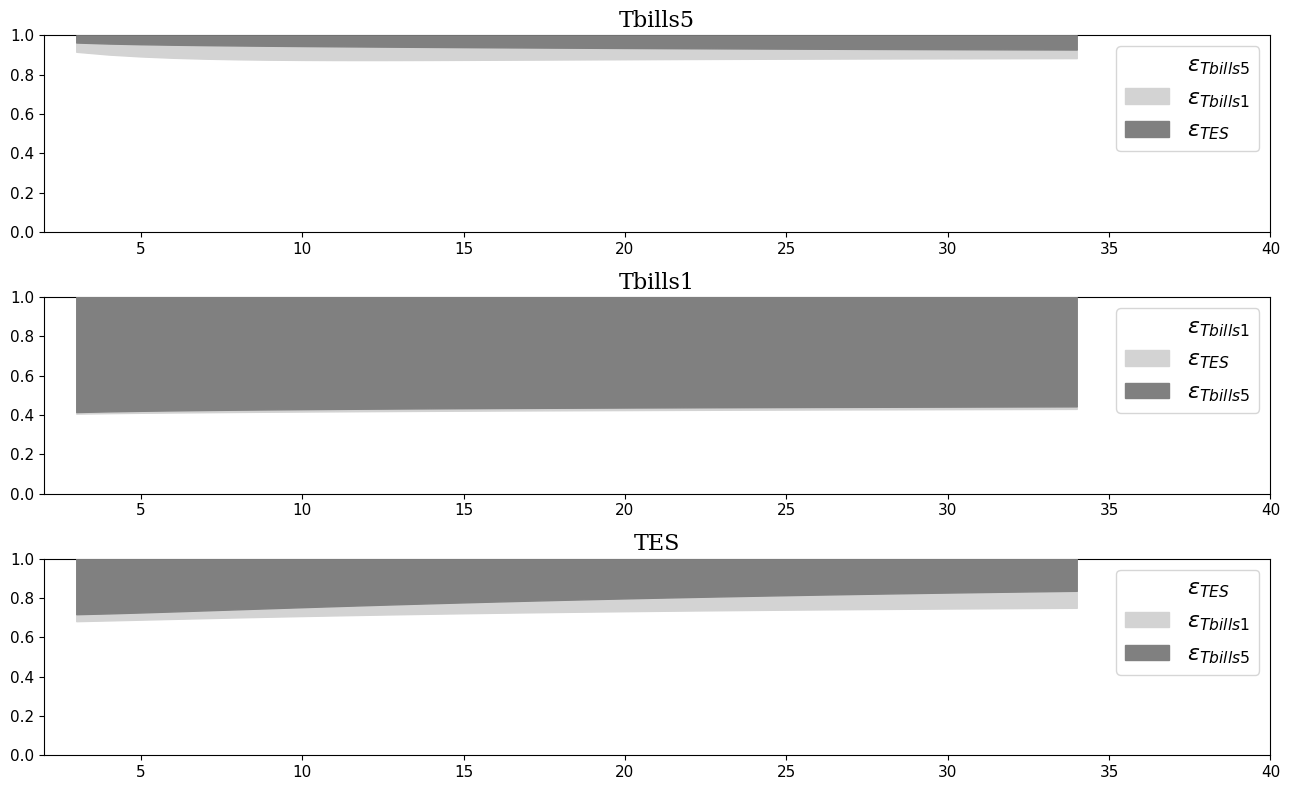

In [28]:
# Assume ws is your FEVD matrix of shape (n, n*s)
n, s_times_n = ws.shape
s = s_times_n // n

ws_trimmed = ws[:, 3*n:]        # drop columns 0…3n-1
s_new = s - 3                   # new number of horizons

def slice_row(row, col):
    """
    Returns the FEVD contributions for variable 'row', starting at dummy
    column 'col' in ws_trimmed, taking every n-th column.
    """
    return ws_trimmed[row, col::n]

# 3. Compute cumulative areas for each row
base_0 = slice_row(0, 0)                   # ε_Tbills5
mid_0  = base_0 + slice_row(0, 1)          # + ε_Tbills1
top_0  = np.ones_like(base_0)              # total = 1

base_1 = slice_row(1, 1)                   # ε_Tbills1
mid_1  = base_1 + slice_row(1, 2)          # + ε_TES
top_1  = np.ones_like(base_1)

base_2 = slice_row(2, 2)                   # ε_TES
mid_2  = base_2 + slice_row(2, 1)          # + ε_Tbills1
top_2  = np.ones_like(base_2)


# 4. Construct the x-axis corresponding to horizons 3…s-1
h0 = 3                                  
H = base_0.shape[0]                       
x = np.arange(h0, h0 + H)   
x = np.arange(h0, h0 + H)

fig, axs = plt.subplots(3, 1, figsize=(13, 8))
plt.subplots_adjust(hspace=0.35)

ax = axs[0]
ax.fill_between(x, 0,      base_0, color='white',     label=r'$\epsilon_{Tbills5}$', zorder=1)
ax.fill_between(x, base_0, mid_0,  color='lightgray', label=r'$\epsilon_{Tbills1}$', zorder=2)
ax.fill_between(x, mid_0,  top_0,  color='gray',      label=r'$\epsilon_{TES}$',    zorder=3)
ax.set_xlim(2, 40)
ax.set_ylim(0, 1)
ax.set_title('Tbills5', fontsize=16, family='serif')
ax.legend(fontsize=16)
ax.tick_params(axis='both', labelsize=11)


ax = axs[1]
ax.fill_between(x, 0,      base_1, color='white',     label=r'$\epsilon_{Tbills1}$', zorder=1)
ax.fill_between(x, base_1, mid_1,  color='lightgray', label=r'$\epsilon_{TES}$',     zorder=2)
ax.fill_between(x, mid_1,  top_1,  color='gray',      label=r'$\epsilon_{Tbills5}$', zorder=3)
ax.set_xlim(2, 40)
ax.set_ylim(0, 1)
ax.set_title('Tbills1', fontsize=16, family='serif')
ax.legend(fontsize=16)
ax.tick_params(axis='both', labelsize=11)

ax = axs[2]
ax.fill_between(x, 0,      base_2, color='white',     label=r'$\epsilon_{TES}$',     zorder=1)
ax.fill_between(x, base_2, mid_2,  color='lightgray', label=r'$\epsilon_{Tbills1}$', zorder=2)
ax.fill_between(x, mid_2,  top_2,  color='gray',      label=r'$\epsilon_{Tbills5}$', zorder=3)
ax.set_xlim(2, 40)
ax.set_ylim(0, 1)
ax.set_title('TES', fontsize=16, family='serif')
ax.legend(fontsize=16)
ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.show()
